# Compare Spectra Runs September 2023

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date :2023 09 19
- last updat : 2023/09/19

- The goal is to generate a first guess of the throuput from the 

# Import

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
mpl.pyplot.set_loglevel (level = 'warning')

import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms


%matplotlib inline
import pickle
import h5py
import seaborn as sns
import copy
from collections import OrderedDict

In [2]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [3]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [4]:
import time
from datetime import datetime,date
from astropy.time import Time
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [5]:
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import fftpack
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import RegularGridInterpolator

In [6]:
from getCalspec.getCalspec import *

In [7]:
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES

class Line:
    """Class modeling the emission or absorption lines."""

    def __init__(self, wavelength, label, atmospheric=False, emission=False, label_pos=[0.007, 0.02],
                 width_bounds=[0.5, 6], use_for_calibration=False):
        """Class modeling the emission or absorption lines. lines attributes contains main spectral lines
        sorted in wavelength.

        Parameters
        ----------
        wavelength: float
            Wavelength of the spectral line in nm
        label: str

        atmospheric: bool
            Set True if the spectral line is atmospheric (default: False)
        emission: bool
            Set True if the spectral line has to be detected in emission. Can't be true if the line is atmospheric.
            (default: False)
        label_pos: [float, float]
            Position of the label in the plot with respect to the vertical lin (default: [0.007,0.02])
        width_bounds: [float, float]
            Minimum and maximum width (in nm) of the line for fitting procedures (default: [1,7])
        use_for_calibration: bool
            Use this line for the dispersion relation calibration, bright line recommended (default: False)

        Examples
        --------
        >>> l = Line(550, label='test', atmospheric=True, emission=True)
        >>> print(l.wavelength)
        550
        >>> print(l.label)
        test
        >>> print(l.atmospheric)
        True
        >>> print(l.emission)
        False
        """
        self.wavelength = wavelength  # in nm
        self.label = label
        self.label_pos = label_pos
        self.atmospheric = atmospheric
        self.emission = emission
        if self.atmospheric:
            self.emission = False
        self.width_bounds = width_bounds
        self.fitted = False
        self.use_for_calibration = use_for_calibration
        self.high_snr = False
        self.fit_lambdas = None
        self.fit_gauss = None
        self.fit_bgd = None
        self.fit_snr = None
        self.fit_fwhm = None
        self.fit_popt = None
        self.fit_pcov = None
        self.fit_popt_gaussian = None
        self.fit_pcov_gaussian = None
        self.fit_chisq = None
        self.fit_eqwidth_mod = None
        self.fit_eqwidth_data = None
        #self.fit_bgd_npar = parameters.CALIB_BGD_NPARAMS
        self.fit_bgd_npar = None


In [8]:
HALPHA = Line(656.3, atmospheric=False, label='$H\\alpha$', label_pos=[-0.01, 0.02], use_for_calibration=True)
HBETA = Line(486.3, atmospheric=False, label='$H\\beta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA = Line(434.0, atmospheric=False, label='$H\\gamma$', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA = Line(410.2, atmospheric=False, label='$H\\delta$', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON = Line(397.0, atmospheric=False, label='$H\\epsilon$', label_pos=[0.001, 0.02], use_for_calibration=True)

HZETA = Line(388.9064, atmospheric=False, label='$H\\zeta$', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA = Line(383.5397, atmospheric=False, label='$H\\eta$', label_pos=[0.001, 0.02], use_for_calibration=False)

HBETA2 = Line(486.3*2, atmospheric=False, label='$H\\beta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HGAMMA2 = Line(434.0*2, atmospheric=False, label='$H\\gamma$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HDELTA2 = Line(410.2*2, atmospheric=False, label='$H\\delta$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HEPSILON2 = Line(397.0*2, atmospheric=False, label='$H\\epsilon$2', label_pos=[0.001, 0.02], use_for_calibration=True)
HZETA2 = Line(388.9064*2, atmospheric=False, label='$H\\zeta$2', label_pos=[0.001, 0.02], use_for_calibration=False)
HETA2 = Line(383.5397*2, atmospheric=False, label='$H\\eta$2', label_pos=[0.001, 0.02], use_for_calibration=False)

O2_1 = Line(760.3, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3
O2_2 = Line(763.1, atmospheric=True, label='$O_2$',label_pos=[0.001, 0.02], use_for_calibration=True)  # libradtran paper fig.3

O2B = Line(687.472, atmospheric=True, label=r'$O_2(B)$',  # 687.472 is a weighted average of the O2B line simulated by Libradtran
           label_pos=[0.001, 0.02], use_for_calibration=True)  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Y = Line(898.765, atmospheric=True, label=r'$O_2(Y)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
O2Z = Line(822.696, atmospheric=True, label=r'$O_2(Z)$',
           label_pos=[0.001, 0.02])  # https://en.wikipedia.org/wiki/Fraunhofer_lines
# H2O = Line( 960,atmospheric=True,label='$H_2 O$',label_pos=[0.007,0.02],width_bounds=(1,50))  #
H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
              width_bounds=[5, 30])  # libradtran paper fig.3, broad line
ATMOSPHERIC_LINES = [O2_1, O2_2, O2B, O2Y, O2Z, H2O_1]


H2O_1 = Line(935, atmospheric=True, label=r'$H_2 O$', label_pos=[0.001, 0.02],  # MFL: don't these need different labels?
             width_bounds=[5, 30])  # libradtran paper fig.3, broad line
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

#my_calib_lines_etador = Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON,HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,O2_1,O2_2],hydrogen_only=True,atmospheric_lines=True, redshift=0, emission_spectrum=False)
#hydrogen_lines_order1 =  Lines([HALPHA,HBETA,HGAMMA,HDELTA,HEPSILON])
#hydrogen_lines_order2 =  Lines([HBETA2,HGAMMA2,HDELTA2,HEPSILON2,HZETA2,HETA2])
#oxygen_lines_order1 = Lines([O2_1,O2_2])

In [9]:
#ax.plot([x_O2_1,x_O2_1],[72,100],'b-',lw=3)
#ax.annotate(O2_1.label, xy=(x_O2_1, 80), color='b',fontsize=20,fontweight='bold')

In [10]:
from getCalspec.getCalspec import getCalspecDataFrame

In [11]:
dict_sedfilename = {'HD38666': "mucol_stis_005.fits", 
            'HD42525': "eta1dor_stis_004.fits",
            'HD185975': "hd185975_stis_003.fits",
            'HD074000': "hd074000_stis_003.fits",
            'HD60753' : "hd60753_stis_003.fits",
            'HD111980': "hd111980_stis_003.fits",
            'HD37962':  "hd37962_stis_005.fits",
            'HD031128' : "hd031128_stis_005.fits",
            'HD14943' : "hd14943_stis_005.fits",
            'HD38949' : "hd38949_stis_005.fits",
            'HD60753' : "hd60753_stis_004.fits",
             'HD200654': "hd200654_stis_006.fits",  
             'HD115169': "hd115169_stis_003.fits",
             'HD142331': "hd142331_stis_004.fits", 
             'HD167060': "hd167060_stis_004.fits", 
             'HD146233': "18sco_stis_004.fits"  
              }         

In [12]:
list_sedtargetnames = ["HD160617","HD185975","HD205905","HD009051","HD2811","HD200654",'FEIGE110']

## absorption band patches

In [13]:
dict_absbands = {} 
dict_absbands["O3"] = (550.,650.,0)
dict_absbands["O2_1"] = (685.,695.,1)
dict_absbands["O2_2"] = (760.,770.,1)
dict_absbands["H2O_1"] = (715.,735.,2)
dict_absbands["H2O_2"] = (815.,835.,2)
dict_absbands["H2O_3"] = (925.,980.,2)
absbands_colors = ['yellow','cyan','green']

# Functions

- filtering here

https://stackoverflow.com/questions/20618804/how-to-smooth-a-curve-in-the-right-way

In [14]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)

In [15]:
def atmpatt_Dataf_to_np(df):
    """
    
    atmpatt_Dataf_to_np : convert pandas dtaframe on abs pattern into numpy array
    
    """
    o2_cols = []
    for tabcol in df.columns:
        if 'o2_' in tabcol and 'no2_' not in tabcol:
            o2_cols.append(tabcol)
            
    no2_cols = []
    for tabcol in df.columns:
        if 'no2_' in tabcol:
            no2_cols.append(tabcol)
            
            
    h2o_cols = []
    for tabcol in df.columns:
        if 'h2o_' in tabcol:
            h2o_cols.append(tabcol)
            
            
    o3_cols = []
    for tabcol in df.columns:
        if 'o3_' in  tabcol:
            o3_cols.append(tabcol)
            
            
    data_wl = df["wl"].to_numpy()
    data_o2 = df[o2_cols].to_numpy()
    data_o3 = df[o3_cols].to_numpy()
    data_h2o = df[h2o_cols].to_numpy()
    data_no2 = df[no2_cols].to_numpy()
    
    
    return data_wl, data_o2, data_o3, data_h2o, data_no2
    
    

In [16]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [17]:
def GetColumnHfData(h5spectra,list_of_keys,nameval):
    """
    Extract h5file atttribute 
    
    parameters
      hf           : descriptor of h5 file
      list_of_keys : list of exposures
      nameval      : name of the attribute
      
    return
      the array of values in the order of 
    """
    

    all_data = []
    for key in list_of_keys:
        group=h5spectra.get(key)
        val=group.attrs[nameval]
        all_data.append(val)
    return all_data

In [18]:
def reorder(df,all_subgroup_keys):
    
    if 'me_az_rms' in all_subgroup_keys:
        df = df.reindex(columns=['index',
                         'exposure',
                         # info added in July 2023        
                         'expo_instrument',
                         'expo_id',
                         'physical_filter', 
                         'obs_id', 
                         'exposure_time',
                         'dark_time',
                         'observation_type', 
                         'observation_reason', 
                         'day_obs', 
                         'seq_num',
                         'group_name',
                         'group_id',
                         'target_name',
                         'science_program',
                         'tracking_ra',
                         'tracking_dec',
                         'sky_angle',
                         'azimuth',
                         'zenith_angle',
                         'mjd',
                         'jd',    
                         #end of info added in july 2023        
                         'spec_date_obs',
                         'spec_target_label','spec_filter_label',
                         'spec_airmass',
                         'spec_pressure',
                         'spec_temperature',
                         'spec_humidity',
                         'spec_hour_angle',
                         'spec_parallactic_angle',
                         'spec_camera_angle',
                         'spec_order',
                         "spec_header_target",
                         "spec_header_redshift",
                         "spec_header_grating",
                         "spec_header_rotangle",
                         "spec_header_d2ccd",
                         "spec_header_lshift",
                         "spec_header_parangle",
                         "spec_header_targetx",
                         "spec_header_targety",
                         "spec_header_lbda_ref",
                         "spec_header_pixshift",
                         "spec_header_psf_reg",
                         "spec_header_trace_r",  
                         "spec_header_chi2_fit", 
                         "spec_header_a2_fit",
                         "spec_header_am_fit",
                         "spec_header_meanfwhm",
                         "spec_header_version",
                         "spec_header_rebin",
                         "spec_header_date-obs",
                         "spec_header_exptime",
                         "spec_header_airmass",
                         "spec_header_dec",
                         "spec_header_ha",
                         "spec_header_outtemp",
                         "spec_header_outpress",
                         "spec_header_outhum",
                         "spec_header_filter",
                         "spec_header_cam_rot",
                         "spec_header_s_x0",
                         "spec_header_s_y0",
                         "spec_header_s_xmin",    
                         "spec_header_s_xmax",                                             
                         "spec_header_s_ymin",    
                         "spec_header_s_ymax",                                                                                                                
                         "spec_header_s_nx",
                         "spec_header_s_ny",
                         "spec_header_s_dec",
                         "spec_header_s_sat",
                         "spec_spectrogram_x0",
                         "spec_spectrogram_y0",
                         "spec_spectrogram_xmin",
                         "spec_spectrogram_xmax",
                         "spec_spectrogram_ymin",
                         "spec_spectrogram_ymax",
                         "spec_spectrogram_deg",
                         "spec_spectrogram_saturation",    
                         "spec_spectrogram_Nx",
                         "spec_spectrogram_Ny",
                         "me_az_rms",
                         "me_el_rms",
                         "me_rot_rms",
                         "me_image_az_rms",
                         "me_image_el_rms",
                         "me_image_rot_rms",
                        ])
    else:
        df = df.reindex(columns=['index',
                         'exposure',
                         # info added in July 2023        
                         'expo_instrument',
                         'expo_id',
                         'physical_filter', 
                         'obs_id', 
                         'exposure_time',
                         'dark_time',
                         'observation_type', 
                         'observation_reason', 
                         'day_obs', 
                         'seq_num',
                         'group_name',
                         'group_id',
                         'target_name',
                         'science_program',
                         'tracking_ra',
                         'tracking_dec',
                         'sky_angle',
                         'azimuth',
                         'zenith_angle',
                         'mjd',
                         'jd',   
                         #end of info added in july 2023           
                         'spec_date_obs',
                         'spec_target_label','spec_filter_label',
                         'spec_airmass',
                         'spec_pressure',
                         'spec_temperature',
                         'spec_humidity',
                         'spec_hour_angle',
                         'spec_parallactic_angle',
                         'spec_camera_angle',
                         'spec_order',
                         "spec_header_target",
                         "spec_header_redshift",
                         "spec_header_grating",
                         "spec_header_rotangle",
                         "spec_header_d2ccd",
                         "spec_header_lshift",
                         "spec_header_parangle",
                         "spec_header_targetx",
                         "spec_header_targety",
                         "spec_header_lbda_ref",
                         "spec_header_pixshift",
                         "spec_header_psf_reg",
                         "spec_header_trace_r",  
                         "spec_header_chi2_fit", 
                         "spec_header_a2_fit",
                         "spec_header_am_fit",
                         "spec_header_meanfwhm",
                         "spec_header_version",
                         "spec_header_rebin",
                         "spec_header_date-obs",
                         "spec_header_exptime",
                         "spec_header_airmass",
                         "spec_header_dec",
                         "spec_header_ha",
                         "spec_header_outtemp",
                         "spec_header_outpress",
                         "spec_header_outhum",
                         "spec_header_filter",
                         "spec_header_cam_rot",
                         "spec_header_s_x0",
                         "spec_header_s_y0",
                         "spec_header_s_xmin",    
                         "spec_header_s_xmax",                                             
                         "spec_header_s_ymin",    
                         "spec_header_s_ymax",                                                                                                                
                         "spec_header_s_nx",
                         "spec_header_s_ny",
                         "spec_header_s_dec",
                         "spec_header_s_sat",
                         "spec_spectrogram_x0",
                         "spec_spectrogram_y0",
                         "spec_spectrogram_xmin",
                         "spec_spectrogram_xmax",
                         "spec_spectrogram_ymin",
                         "spec_spectrogram_ymax",
                         "spec_spectrogram_deg",
                         "spec_spectrogram_saturation",    
                         "spec_spectrogram_Nx",
                         "spec_spectrogram_Ny",
                        ])
        
    return df

In [19]:
def get_seq(row):
    return row - (row//100000)*100000

In [20]:
def GetSpectraH5(h5spectra,factor=1.):
    """
    GetSpectraH5(dict_spectra)
    
    input:
      h5spectra h5 file descriptor
 
    
    return
      - list of dataframes
    """
    
    # indexes in H5 file
    list_of_keys = list(h5spectra.keys())
    sorted_spectra_keys = sorted(list_of_keys)
    
    # pick one key    
    key_sel =  sorted_spectra_keys[0]
    # pick one group
    group = h5spectra.get(key_sel)
    
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)  
        

    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, sorted_spectra_keys ,key)
        df_info[key] = arr
    
    df_info = reorder(df_info,all_subgroup_keys)
    
    
    #correction_area = 1.06/1.13
    correction_area = 1

    all_df = []  # container for spectra
    
    
    idx=0
    for key in sorted_spectra_keys :
        
        group = h5spectra.get(key)
               
        df = pd.DataFrame()
        data_next_order=  np.array(group.get("spec_data_next_order"))
        
        df["all_lambdas"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes"] = np.array(group.get("spec_data")) / correction_area*factor 
        df["all_fluxes_err"] = np.array(group.get("spec_err")) /correction_area*factor
        
        
        df["all_lambdas_order2"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes_order2"] = np.array(group.get("spec_data_next_order"))/ correction_area*factor 
        df["all_fluxes_err_order2"] = np.array(group.get("spec_err_next_order"))/ correction_area*factor 
        
        all_df.append(df)
        
        idx+=1
        
        
    #calculate refhour    
    all_datetime = [ Time(str_time).to_datetime() for str_time in df_info['spec_date_obs'] ]
    start_time_str = df_info["spec_date_obs"].min()
    stop_time_str = df_info["spec_date_obs"].max()
    startTime = Time(start_time_str).to_datetime()
    endTime =  Time(stop_time_str).to_datetime() 
    all_reftime = [ (Time(str_time).to_datetime()-startTime).seconds/3600. for str_time in df_info['spec_date_obs'] ]
    df_info["refhour"] = all_reftime
    #calculate number
    df_info["number"] = df_info[['exposure']].apply(lambda x: get_seq(x))
        
    return df_info , all_df

In [21]:
def GetSpectraFiltered(dict_spectra,list_of_bad_spectra,factor = 1.):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - dict_spectra
      - ist_of_bad_spectra
    
    return
      - filtered infos, filtered spectra
    """
    
    # factor to correct fluxes (over estimated collection surface)
    #correction_area = 1.06/1.13
    correction_area = 1
    
    
    
    list_of_columns = ["number","object",'dateobs','refhour','airmass','pressure','temperature','humidity','filename','targetx_pix', 'targety_pix','rotangle', 'd2ccd']   
        

    all_df = []  # container for spectra
    
    df_info = pd.DataFrame(columns=list_of_columns)
    
    idx=0       # counter on input spectra
    idx_out = 0 # counter on save spectra
    #for key, value in dict_spectra.items():
    sorted_dict_spectra_items = sorted(dict_spectra.items())
    for key, value in sorted_dict_spectra_items:
        
        
        if int(value["number"]) not in list_of_bad_spectra:
        
            
            df_info.loc[idx] = [int(value["number"]),value["object"],value["dateobs"],value["refhour"],value["airmass"],value["pressure"],value["temperature"],value["humidity"],key,value['targetx_pix'],value['targety_pix'],value['rotangle'], value['d2ccd']] 
        
            df = pd.DataFrame()
            df["all_lambdas"] = value["all_lambdas"]
            df["all_fluxes"] = value["all_fluxes"]/correction_area*factor
            df["all_fluxes_err"] = value["all_fluxes_err"]*factor
        
            if 'all_lambdas_order2' in value.keys():
                df["all_lambdas_order2"] = value["all_lambdas_order2"]
                df["all_fluxes_order2"] = value["all_fluxes_order2"]/correction_area*factor
                df["all_fluxes_err_order2"] = value["all_fluxes_err_order2"]*factor
               
            all_df.append(df)
            idx_out+=1  # increase count on saved spectra
            
        else:
            num = int(value["number"])
            msg = f"Remove spectrum {idx} for exposure {num}"
            print(msg)
            
        idx+=1
            

        
    return df_info,all_df

In [22]:
def GetSpectraH5Filtered(h5spectra,list_of_bad_spectra,factor=1.):
    """
    GetSpectraH5Filtered(dict_spectra)
    
    input:
      h5spectra h5 file descriptor
 
    return
      - list of dataframes
    """
    
    # indexes in H5 file
    list_of_keys = list(h5spectra.keys())
    sorted_spectra_keys = sorted(list_of_keys)
    
    # compute the list of filtered spectra
    sorted_selected_spectra_keys = [] 
    for key in sorted_spectra_keys:
        key_num = int(key)
        seq = key_num - (key_num//100000)*100000
        if seq not in list_of_bad_spectra and str(seq) not in list_of_bad_spectra:
            sorted_selected_spectra_keys.append(key)
       
    
    # pick one key    
    key_sel =  sorted_selected_spectra_keys[0]
    # pick one group
    group = h5spectra.get(key_sel)
    
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)  
        

    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, sorted_selected_spectra_keys ,key)
        df_info[key] = arr
    
    df_info = reorder(df_info,all_subgroup_keys)
    
    
    #correction_area = 1.06/1.13
    correction_area = 1

    all_df = []  # container for spectra
    
  
    
    idx=0
    for key in sorted_selected_spectra_keys:
        
        group = h5spectra.get(key)
               
        df = pd.DataFrame()
        data_next_order=  np.array(group.get("spec_data_next_order"))
        
        df["all_lambdas"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes"] = np.array(group.get("spec_data")) / correction_area*factor 
        df["all_fluxes_err"] = np.array(group.get("spec_err")) /correction_area*factor
        
        
        df["all_lambdas_order2"] = np.array(group.get("spec_lambdas"))
        df["all_fluxes_order2"] = np.array(group.get("spec_data_next_order"))/ correction_area*factor 
        df["all_fluxes_err_order2"] = np.array(group.get("spec_err_next_order"))/ correction_area*factor 
        
        all_df.append(df)
        
        idx+=1
        
        
    #calculate refhour    
    all_datetime = [ Time(str_time).to_datetime() for str_time in df_info['spec_date_obs'] ]
    start_time_str = df_info["spec_date_obs"].min()
    stop_time_str = df_info["spec_date_obs"].max()
    startTime = Time(start_time_str).to_datetime()
    endTime =  Time(stop_time_str).to_datetime() 
    all_reftime = [ (Time(str_time).to_datetime()-startTime).seconds/3600. for str_time in df_info['spec_date_obs'] ]
    df_info["refhour"] = all_reftime
    #calculate number
    df_info["number"] = df_info[['exposure']].apply(lambda x: get_seq(x))
        
    return df_info , all_df

In [23]:
def FindPairOfExposures(df):
    """
    
    Find pair of exposures at similar airmass, one before culmination, the other one after the exposure
    
    - input : pandas dataframe with infos
    - output : pandas dataframe with pairs
    
    """
    
    
 
    # the culmination  
    idx_zmin = df["airmass"].idxmin()
    
    # split this dataframe into 2
    
    # df before culmination
    df1 = df.iloc[0:idx_zmin]
    
    # df after culmination
    df2 = df.iloc[idx_zmin+1:-1]
    
    #print(df1)
    
    #print(df2)
    
    # loop on exposure before culmination
    #for irow in range(0,idx_zmin):
        # print(irow,df1.iloc[irow][["number","airmass"]])
        
    dist = np.abs(df1["airmass"][np.newaxis, :] - df2["airmass"][:, np.newaxis])
    #print(dist)
    closest_idx = np.argmin(dist, axis=0)
    closest_id = df2.iloc[closest_idx]["number"].to_numpy()
    df_output = pd.DataFrame({"idx1": np.arange(0,idx_zmin), 
                              "idx2": closest_idx+idx_zmin+1,
                              "num1":df1["number"],
                              "num2":closest_id,
                              "z1":df1["airmass"].values,
                              "z2":df2.iloc[closest_idx]["airmass"].to_numpy()})

    df_output["zdiff"] =  df_output["z2"]-df_output["z1"]
    df_output["dtime"] = df2.iloc[closest_idx]["refhour"].to_numpy()- df1["refhour"] 
    return df_output
    

In [24]:
def FindPairOfExposuresFromFirst(df):
    """
    
    - input : pandas dataframe with infos
    - output : pandas dataframe with pairs
    
    """ 
 

    idx_start = 0
    
    # split this dataframe into 2
    
    # df before culmination
    df1 = df.iloc[:idx_start+1]
    
    # df after culmination
    df2 = df.iloc[idx_start+1:]
    N2=len(df2)
    

    df1_new = df1.copy(deep=True)
    df1_new = pd.concat([df1]*(N2),axis=0)
 
    df1=df1_new
    N1=len(df1)
   
    df_output = pd.DataFrame({"idx1": np.full(N1,0), 
                              "idx2": np.arange(1,N2+1),
                              "num1":df1["number"].values,
                              "num2":df2["number"].values,
                              "z1":df1["airmass"].values,
                              "z2":df2["airmass"].values,
                              "t1":df1["refhour"].values,
                              "t2":df2["refhour"].values})

    df_output["zdiff"] =  df_output["z2"]-df_output["z1"]
    df_output["dtime"] = df_output["t2"]-df_output["t1"]
    return df1,df2,df_output
    

In [25]:
chi2_fit_max = 25
chi2_fit_min = 0

d2ccd_max = 189
d2ccd_min = 186.6

pixshift_max = 0.3
pixshift_min = -0.3

xtarget_min = 50
xtarget_max = 250

ytarget_min = 700
ytarget_max = 1000

In [26]:
def SelectionCriteria(row):
    """
    Calculate the Spectrum selection flag on pandas dataframe
    call it on a dataframe df as   
    flag_selection = df[["spec_header_d2ccd","spec_header_targetx","spec_header_targety"]].apply(SelectionCriteria,axis=1)
    """
    d2ccd = row["spec_header_d2ccd"]
    xtarget = row["spec_header_targetx"]
    ytarget = row["spec_header_targety"]
    
    flag_selection_d2ccd = (d2ccd > d2ccd_min)  and (d2ccd < d2ccd_max) 
    flag_selection_target = (xtarget > xtarget_min)  and (xtarget < xtarget_max ) and (ytarget > ytarget_min)  and (ytarget < ytarget_max )
    flag_selection = flag_selection_d2ccd and flag_selection_target
    return flag_selection

# Constants

# Initialisation

In [27]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [28]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2023-09-19 13:34:57 dagoret-nb __main__[62820] INFO LA time:06:34:57


2023-09-19 13:34:57,803 dagoret-nb __main__[62820] INFO LA time:06:34:57
2023-09-19 13:34:57 dagoret-nb __main__[62820] INFO NY time:09:34:57


2023-09-19 13:34:57,805 dagoret-nb __main__[62820] INFO NY time:09:34:57
2023-09-19 13:34:57 dagoret-nb __main__[62820] INFO London time:14:34:57


2023-09-19 13:34:57,806 dagoret-nb __main__[62820] INFO London time:14:34:57
2023-09-19 13:34:57 dagoret-nb __main__[62820] INFO Paris time:15:34:57


2023-09-19 13:34:57,808 dagoret-nb __main__[62820] INFO Paris time:15:34:57
2023-09-19 13:34:57 dagoret-nb __main__[62820] INFO ************************ START *********************


2023-09-19 13:34:57,809 dagoret-nb __main__[62820] INFO ************************ START *********************


In [29]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [30]:
DATE = 20230914

In [31]:
PATH_EXTRACTED_SPECTRA = "/home/d/dagoret/rubin-user/DATA/AuxtelData2023/ExtractedSpectra/2023-09"
#PATH_EXTRACTED_SPECTRA = "/Volumes/Backup2020/DATA/ExtractedSpectra/2023-09"

In [32]:
list_filterdispersers = ["collimator~holo4_003","empty~holo4_001", "empty~holo4_003"]

In [33]:
all_files_20230912 = ["allspectra_20230912-collimator~holo4_003-PSF2DFFM_REBIN2-specV2.5-oga.hdf5","allspectra_20230912-empty~holo4_001-PSF2DFFM_REBIN2-specV2.5-oga.hdf5","allspectra_20230912-empty~holo4_003-PSF2DFFM_REBIN2-specV2.5-oga.hdf5"]
all_files_20230913 = ["allspectra_20230913-collimator~holo4_003-PSF2DFFM_REBIN2-specV2.5-oga.hdf5","allspectra_20230913-empty~holo4_001-PSF2DFFM_REBIN2-specV2.5-oga.hdf5","allspectra_20230913-empty~holo4_003-PSF2DFFM_REBIN2-specV2.5-oga.hdf5"]
all_files_20230914 = ["allspectra_20230914-collimator~holo4_003-PSF2DFFM_REBIN2-specV2.5-oga.hdf5","allspectra_20230914-empty~holo4_001-PSF2DFFM_REBIN2-specV2.5-oga.hdf5","allspectra_20230914-empty~holo4_003-PSF2DFFM_REBIN2-specV2.5-oga.hdf5"]

In [34]:
if DATE == 20230914:
    all_files = all_files_20230914
    #list_bad_nums = [[94,95,108,109,157,194,195,240],[90,91,100,104,105],[92,93,106,107,237]]
    list_bad_nums = [[94,95,108,109,157,240],[90,91,100,104,105],[92,93,106,107,237]]
elif DATE == 20230913:
    all_files = all_files_20230913
    list_bad_nums = [ [],[315,376],[318,354,376] ]
elif DATE == 20230912:
    all_files = all_files_20230912
    list_bad_nums = [ [327],[],[244,259,260,274,289,304,325,334,349,364,394,418,433] ]

In [35]:
WLMINSEL=350.
WLMAXSEL=1100.
WL= np.arange(WLMINSEL,WLMAXSEL)

In [36]:
deltaWL = np.diff(WL).mean()
WLEXTENDED = np.arange(WLMINSEL-20*deltaWL,WLMAXSEL+20*deltaWL)
WLMINSELEXTENDED = WLEXTENDED.min()
WLMAXSELEXTENDED = WLEXTENDED.max()

# input files

## Get Calspec SED

- Notice we use a relative normalisation factor

In [37]:
dict_f_sed = {}

In [38]:
for targetid in list_sedtargetnames: 
    print(targetid)
    
    
    c = Calspec(targetid)
    c.get_spectrum_fits_filename()  # download the fits file
    tab = c.get_spectrum_table()  # download and return an Astropy table
    arr = c.get_spectrum_numpy()  # download and return a dictionnary of numpy arrays with units
    #c.plot_spectrum()  # download and plot the spectrum
            
    wl = arr['WAVELENGTH'].to_value()/10.
    fl = arr['FLUX'].to_value()*10.
    
    
    sed_w = wl
    sed_f = fl
    
    sed_idx=np.where(np.logical_and(sed_w> WLMINSELEXTENDED ,sed_w< WLMAXSELEXTENDED))[0]
    
    sed_w=sed_w[sed_idx]
    sed_f=sed_f[sed_idx]
    
    # interpolation function
    f_sed = interpolate.interp1d(sed_w,sed_f,bounds_error=False,fill_value="extrapolate")
    
  
    dict_f_sed[targetid] = f_sed 


HD160617
HD185975
HD205905
HD009051
HD2811
HD200654
FEIGE110


In [39]:
sed_m=-2.5*np.log10(sed_f)

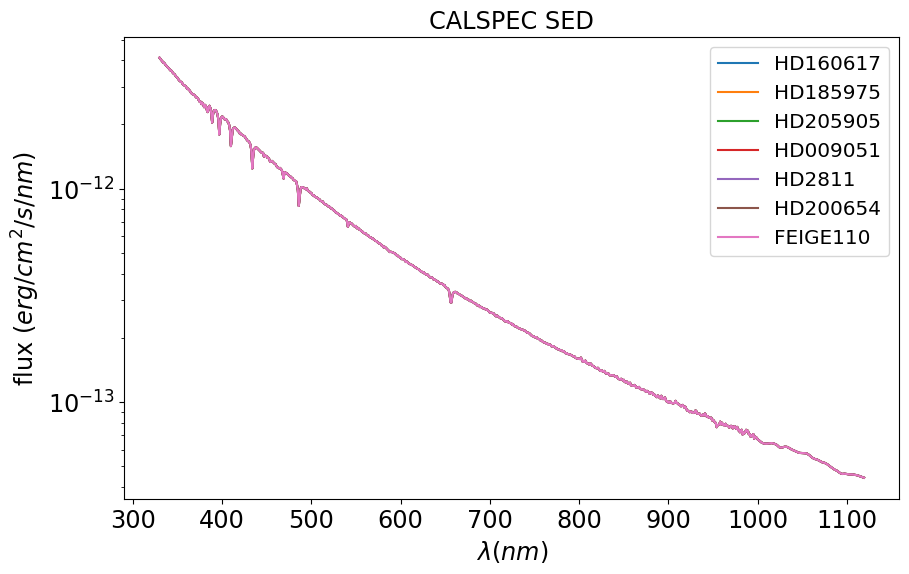

In [40]:
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)

#for targetid, f_sed  in dict_f_sed.items():
for targetid in list_sedtargetnames: 

    sed = f_sed(WLEXTENDED)
    sed_m=-2.5*np.log10(sed)
    
    label= f"{targetid}"
    ax.plot(WLEXTENDED,sed,label=label)
    
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title("CALSPEC SED")
ax.set_yscale('log')
ax.legend(loc='upper right')
#ax2=ax.twinx()
#ax2.plot(sed_w,sed_m,'r-')
#ax2.set_ylabel("mag")

## Smooth the SED

In [41]:
dict_f_sed_sm = {}
span1 = 3
span2 = 5

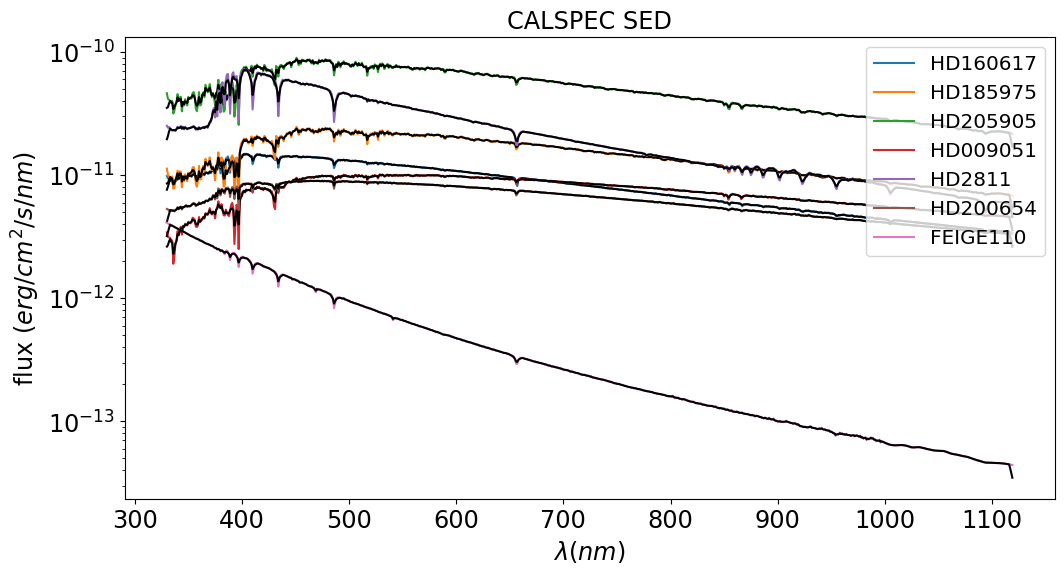

In [42]:
fig=plt.figure(figsize=(12,6))
ax=fig.add_subplot(1,1,1)

for targetid, f_sed  in dict_f_sed.items():
  

    sed = f_sed(WLEXTENDED)
    sed_m=-2.5*np.log10(sed)
    
 
    sed_sm1 = smooth_data_np_convolve(sed,span1)
    sed_sm2 = smooth_data_np_convolve(sed,span2)
    
    sed_sm = 0.5*(sed_sm1+sed)
    #sed_sm[330:] = sed_sm2[330:]
    
    sed_sm_m=-2.5*np.log10(sed_sm)
    
    label= f"{targetid}"
    ax.plot(WLEXTENDED,sed,label=label)
    ax.plot(WLEXTENDED,sed_sm,'k-')
    
    
    # interpolation function
    f_sed_sm = interpolate.interp1d(WLEXTENDED,sed_sm,bounds_error=False,fill_value="extrapolate")
    
    dict_f_sed_sm[targetid] = f_sed_sm 

    
ax.set_xlabel("$\\lambda (nm)$")
ax.set_ylabel("flux $(erg/cm^2/s/nm)$")
ax.set_title("CALSPEC SED")
ax.set_yscale('log')
ax.legend(loc='upper right')
#ax2=ax.twinx()
#ax2.plot(sed_w,sed_m,'r-')
#ax2.set_ylabel("mag")

In [43]:
dict_f_sed = dict_f_sed_sm

In [44]:
def plotallspectra(the_infos,the_spectra,the_list_of_badnums1,thefilterdisperser):
    
    N=len(the_infos)
    NX=4
    NY=N/NX
    
    if NY != int(NY):
        NY= int(NY)+1
    else:
        NY=int(NY)

    fig = plt.figure(figsize=(20,NY*3))

    ny=0
    nx=0

    for idx in range(N):
        iy = idx//NX
        ix = (idx-iy*NX)
    
        ax=fig.add_subplot(NY,NX,idx+1)
    
    
        the_df=the_spectra[idx]
    
        airmassvalue = the_infos.iloc[idx]["spec_header_airmass"]
        num = the_infos.iloc[idx]["number"]
        label_airmass = f" z = {airmassvalue:.2f} ({num})"
        the_target = the_infos.iloc[idx]["spec_target_label"]
    
        #ax.plot(the_df.wavelength,the_df.flux,color=all_colors[ifile])
        if num in the_list_of_badnums1:
            thecolor="r"
        else:
            thecolor="b"
    
        ax.errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], fmt = '-', color=thecolor,capsize = 0.01, ecolor="k", elinewidth = .01,label=the_target)
        ax.set_title(label_airmass)
    
        ax.axvline(HBETA.wavelength,linestyle="-",color="k")
        ax.axvline(HALPHA.wavelength,linestyle="-",color="k")
    
        # O2 line
        ax.axvline(O2_1.wavelength,linestyle="--",color="k")
        #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

        ax.axvline(O2_2.wavelength,linestyle="--",color="k")
        #ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
        ax.legend()
    
    the_title = f"All spectra {DATE}-{thefilterdisperser}"

    plt.suptitle(the_title,size=20,fontweight='bold',y=0.99)    
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)

    fig_filename = f"fig_01-{DATE}-{thefilterdisperser}-allspectra.pdf"
    plt.savefig(fig_filename)
    plt.show()

In [45]:
 all_files

['allspectra_20230914-collimator~holo4_003-PSF2DFFM_REBIN2-specV2.5-oga.hdf5',
 'allspectra_20230914-empty~holo4_001-PSF2DFFM_REBIN2-specV2.5-oga.hdf5',
 'allspectra_20230914-empty~holo4_003-PSF2DFFM_REBIN2-specV2.5-oga.hdf5']

In [46]:
all_infos =  []
all_allspectra = []
all_NBSPECTRA = []
for idxf in range(3):
    inputfile =  all_files[idxf]
    inputdir = PATH_EXTRACTED_SPECTRA
    list_of_badnums1 = list_bad_nums[idxf]
    filterdisperser = list_filterdispersers[idxf]
    
    fullfilename=os.path.join(inputdir,inputfile)
    
    hf =  h5py.File(fullfilename, 'r') 
    list_of_keys = list(hf.keys())
    NBSPECTRA=len(list_of_keys)
    
    infos, all_spectra = GetSpectraH5(hf)
    
    all_infos.append(infos)
    all_allspectra.append(all_spectra)
    all_NBSPECTRA.append(NBSPECTRA) 
     

In [47]:
idxf = 2
the_infos = all_infos[idxf] 
the_spectra = all_allspectra[idxf]
the_list_of_badnums1 = list_bad_nums[idxf]
thefilterdisperser = list_filterdispersers[idxf]

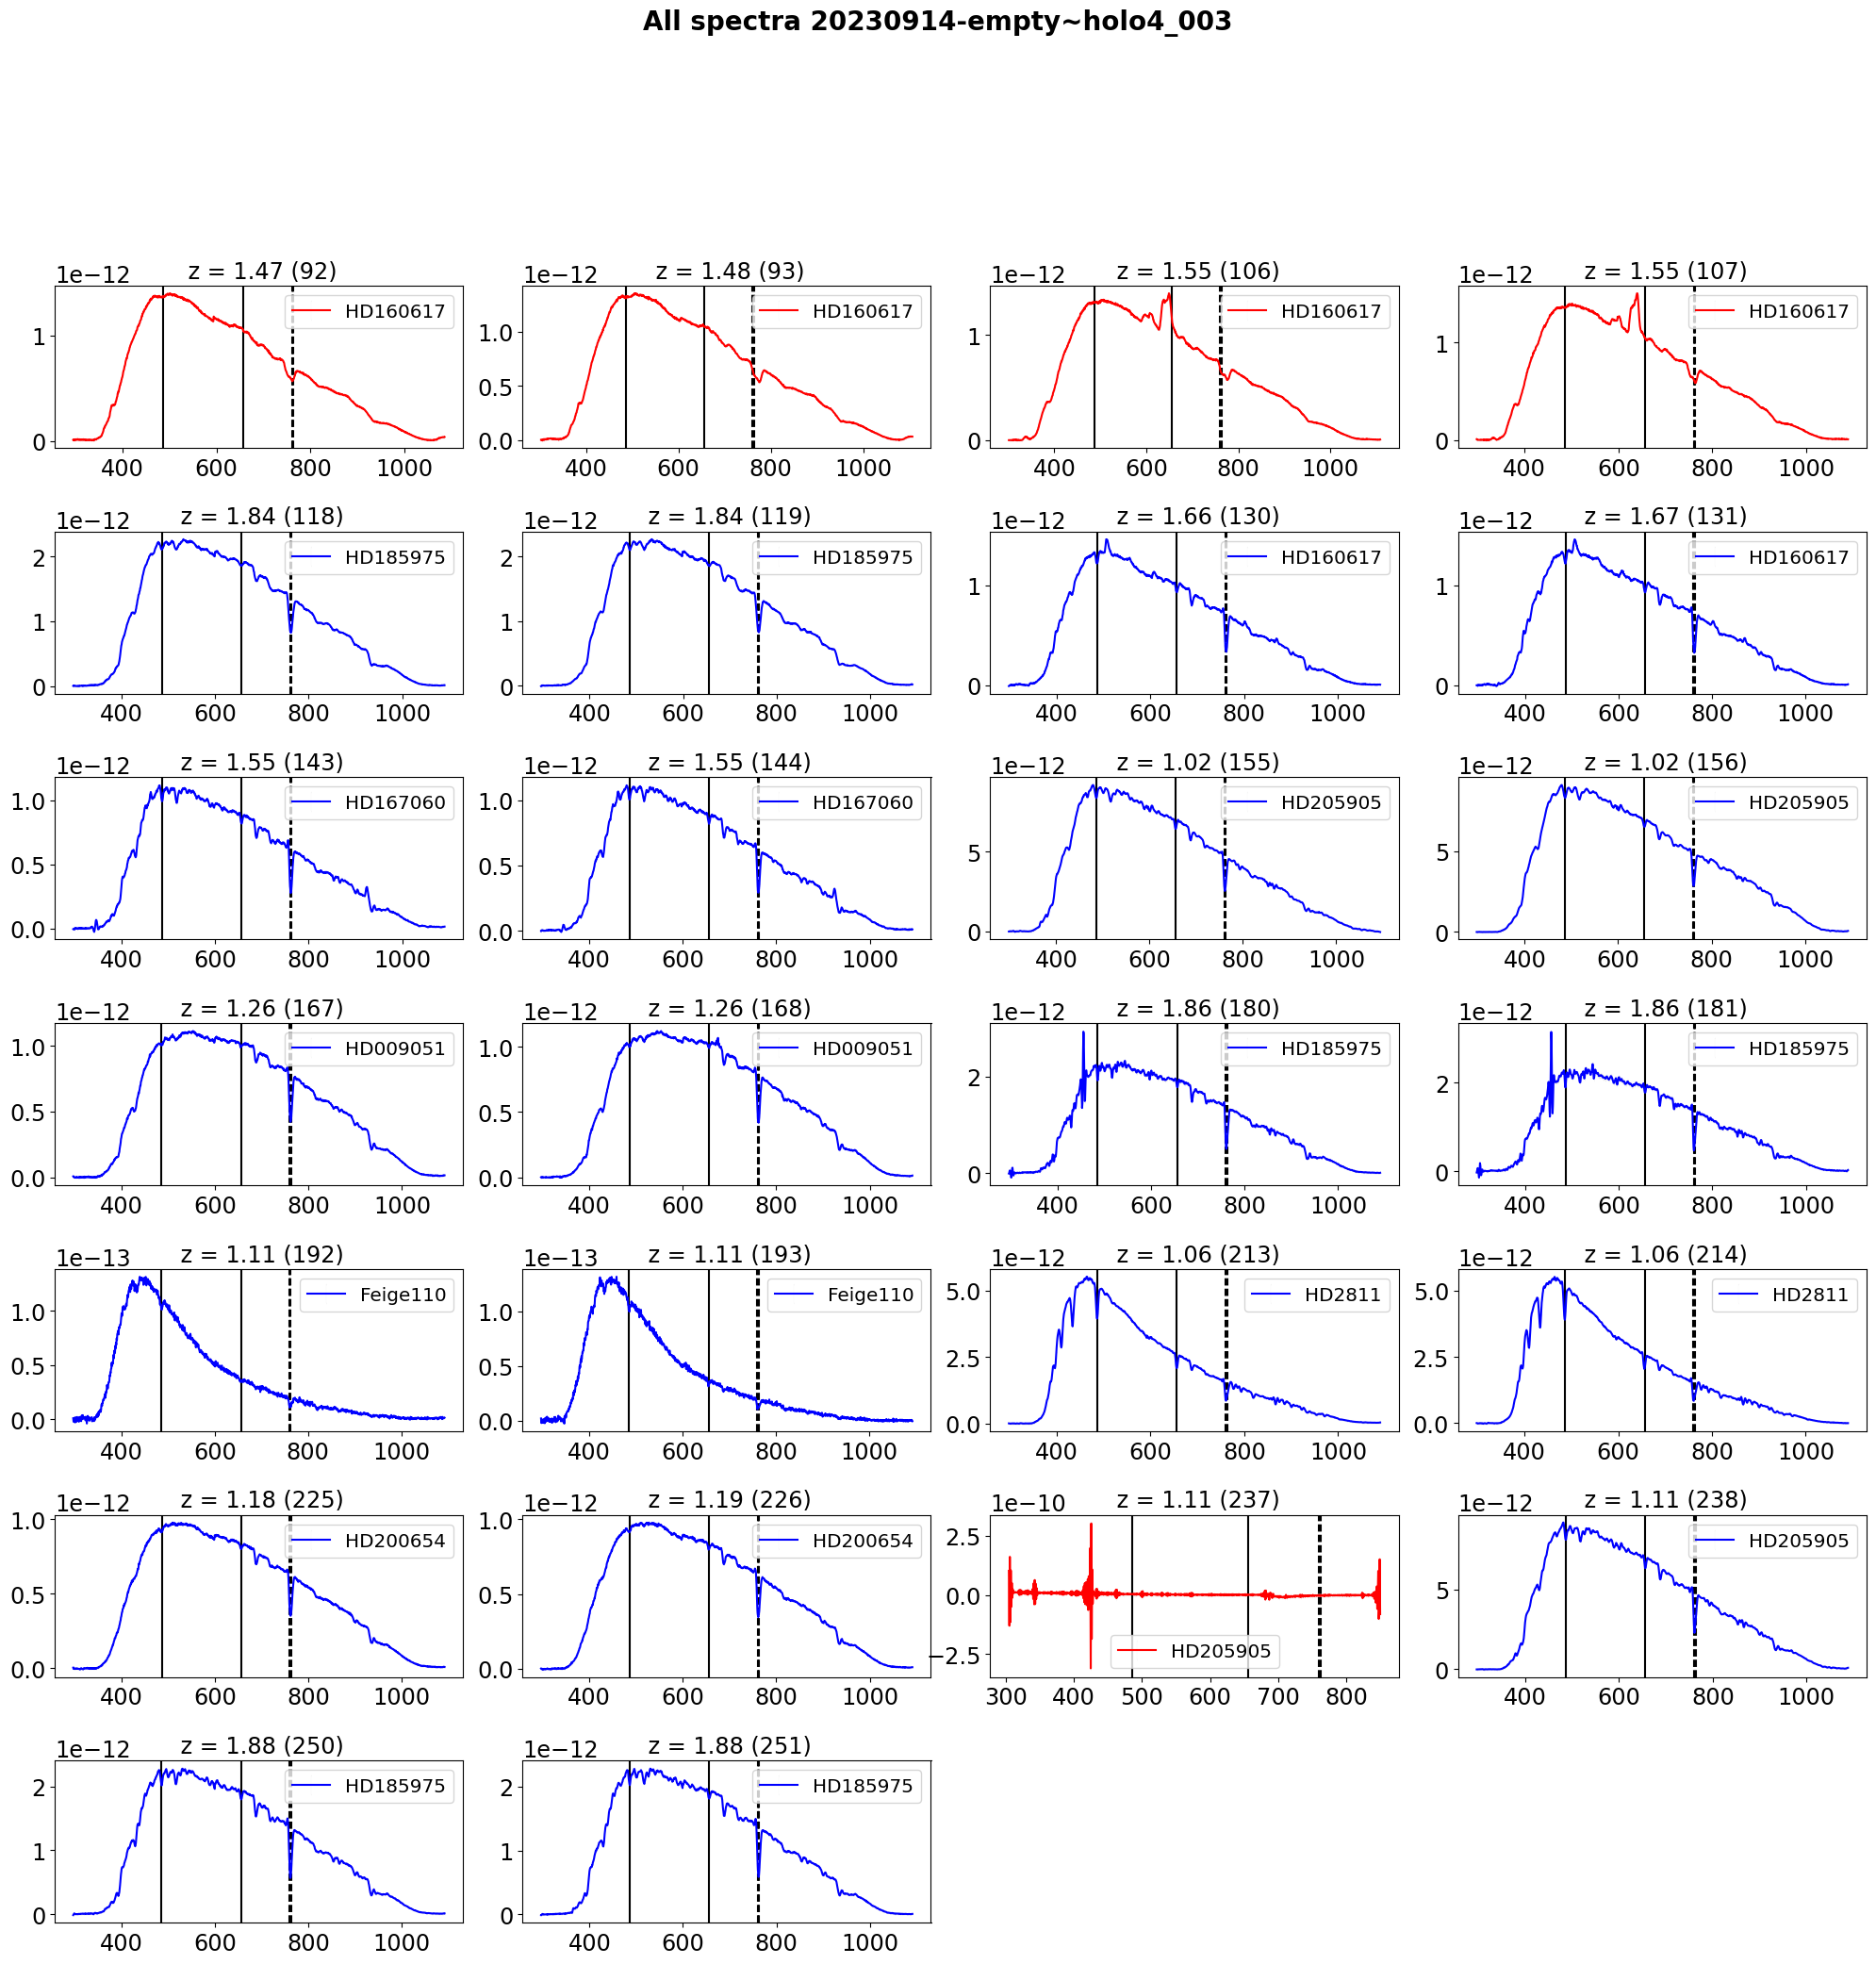

In [48]:
plotallspectra(the_infos,the_spectra,the_list_of_badnums1,thefilterdisperser)

# Filtered spectra : remove bad spectra

In [49]:
all_infos =  []
all_allspectra = []
all_NBSPECTRA = []
for idxf in range(3):
    inputfile =  all_files[idxf]
    inputdir = PATH_EXTRACTED_SPECTRA
    list_of_badnums1 = list_bad_nums[idxf]
    filterdisperser = list_filterdispersers[idxf]
    
    fullfilename=os.path.join(inputdir,inputfile)
    
    hf =  h5py.File(fullfilename, 'r') 
    list_of_keys = list(hf.keys())
    NBSPECTRA=len(list_of_keys)
    
    #infos, all_spectra = GetSpectraH5(hf)
    infos, all_spectra = GetSpectraH5Filtered(hf,list_of_bad_spectra = list_of_badnums1)
    infos.reset_index(drop=True, inplace=True)
    
    all_infos.append(infos)
    all_allspectra.append(all_spectra)
    all_NBSPECTRA.append(NBSPECTRA) 
     

In [50]:
idxf = 0
the_infos = all_infos[idxf] 
the_spectra = all_allspectra[idxf]
the_list_of_badnums1 = list_bad_nums[idxf]
thefilterdisperser = list_filterdispersers[idxf]

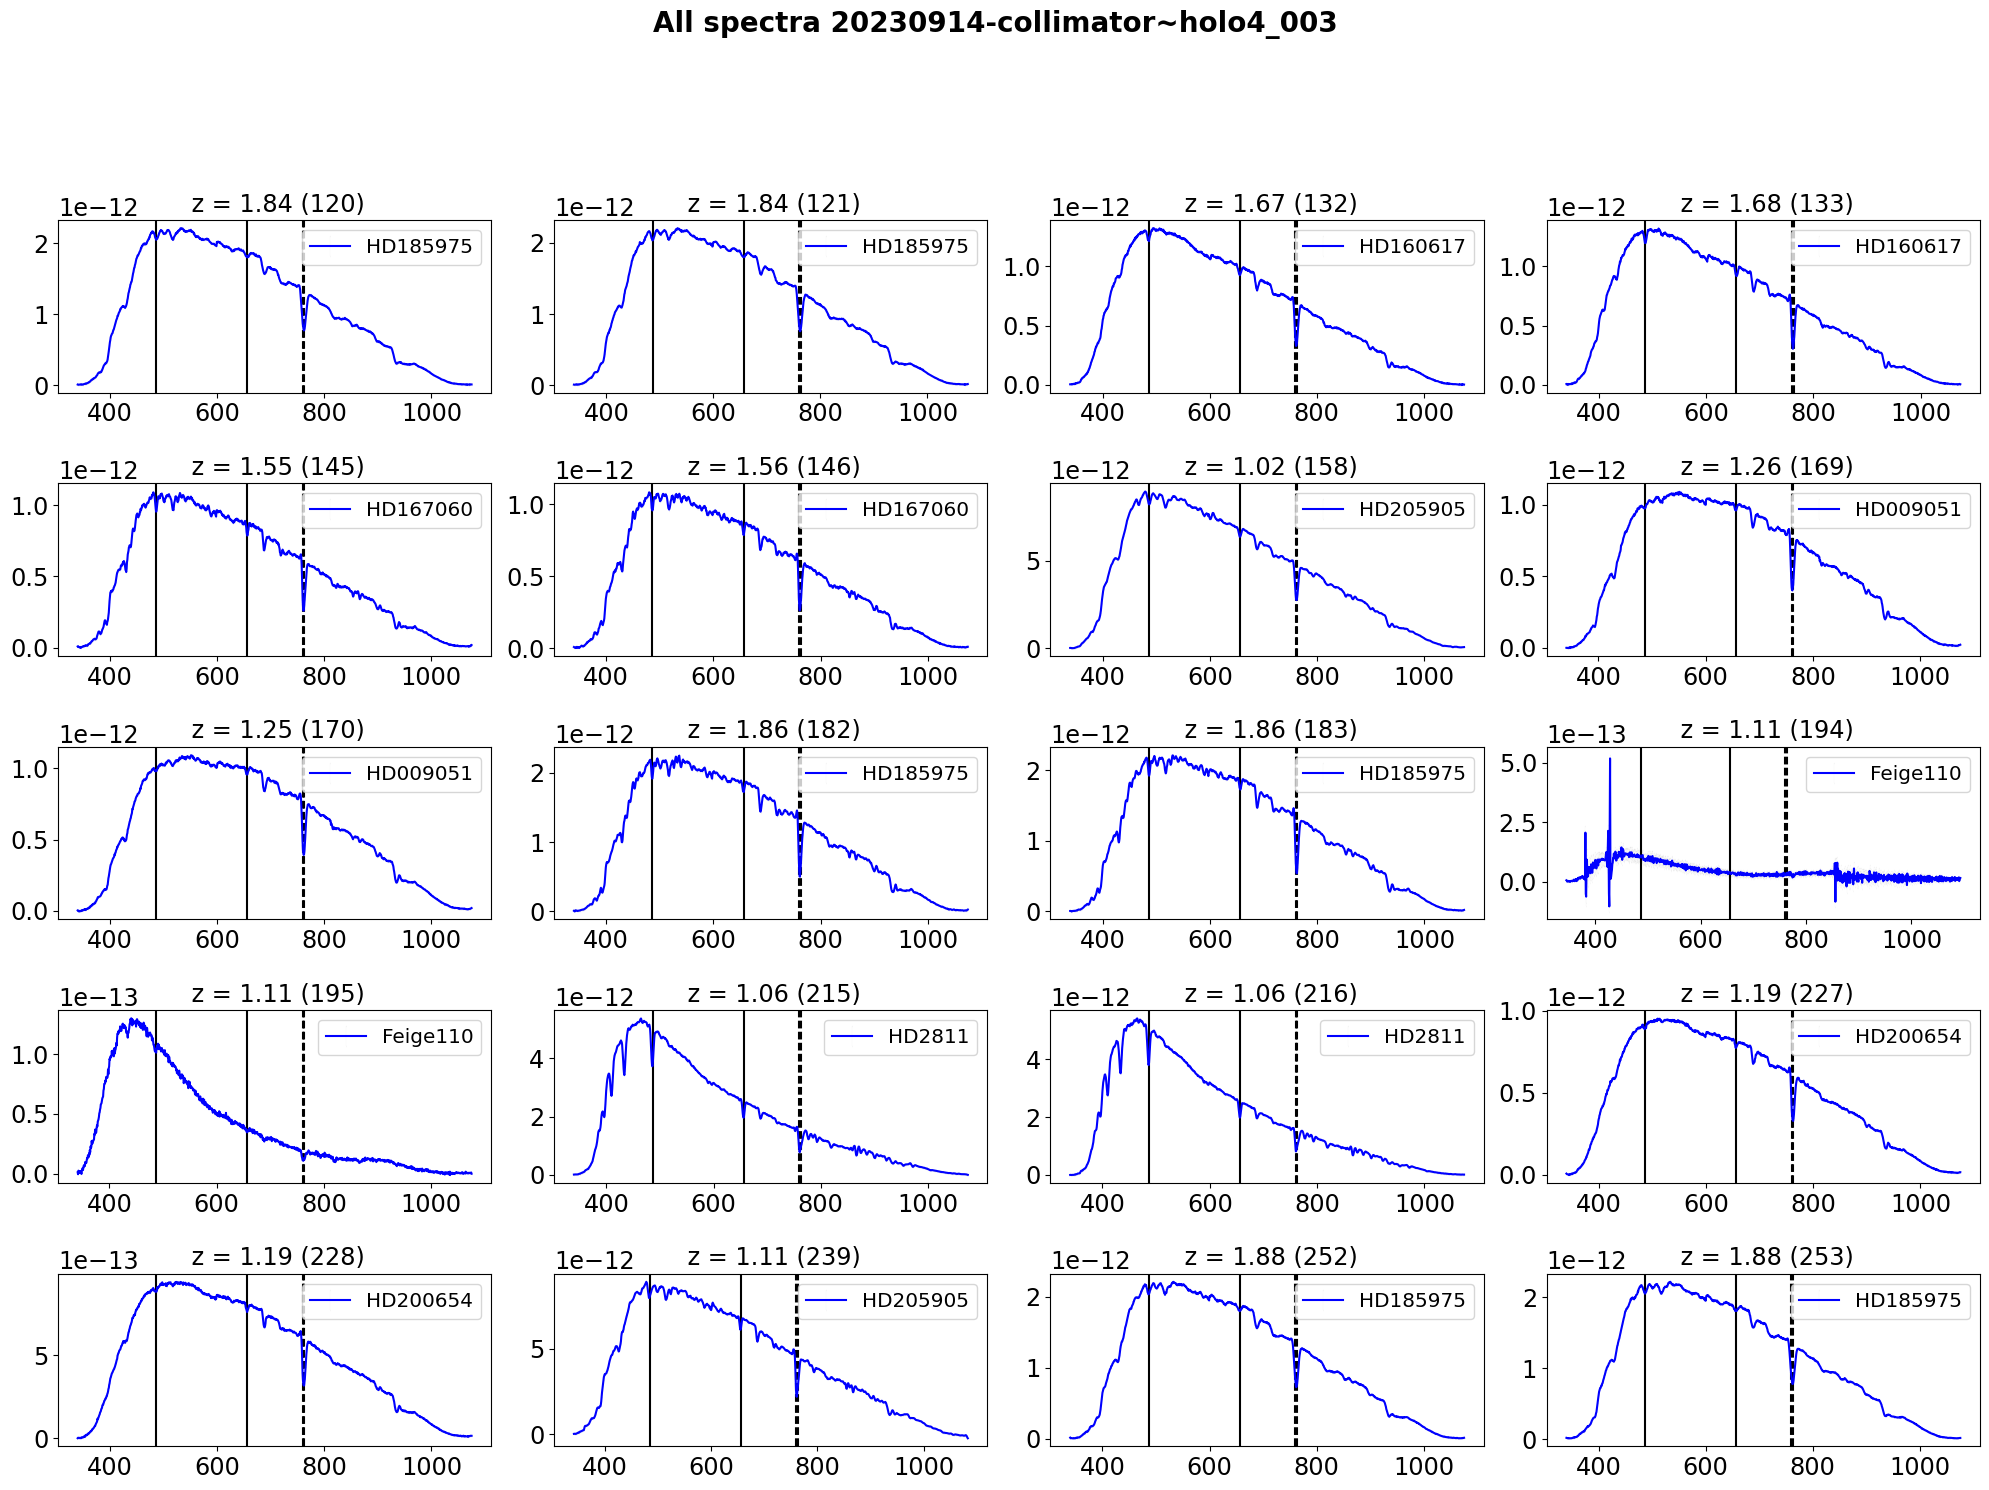

In [51]:
plotallspectra(the_infos,the_spectra,the_list_of_badnums1,thefilterdisperser)

In [52]:
idxf = 1
the_infos = all_infos[idxf] 
the_spectra = all_allspectra[idxf]
the_list_of_badnums1 = list_bad_nums[idxf]
thefilterdisperser = list_filterdispersers[idxf]

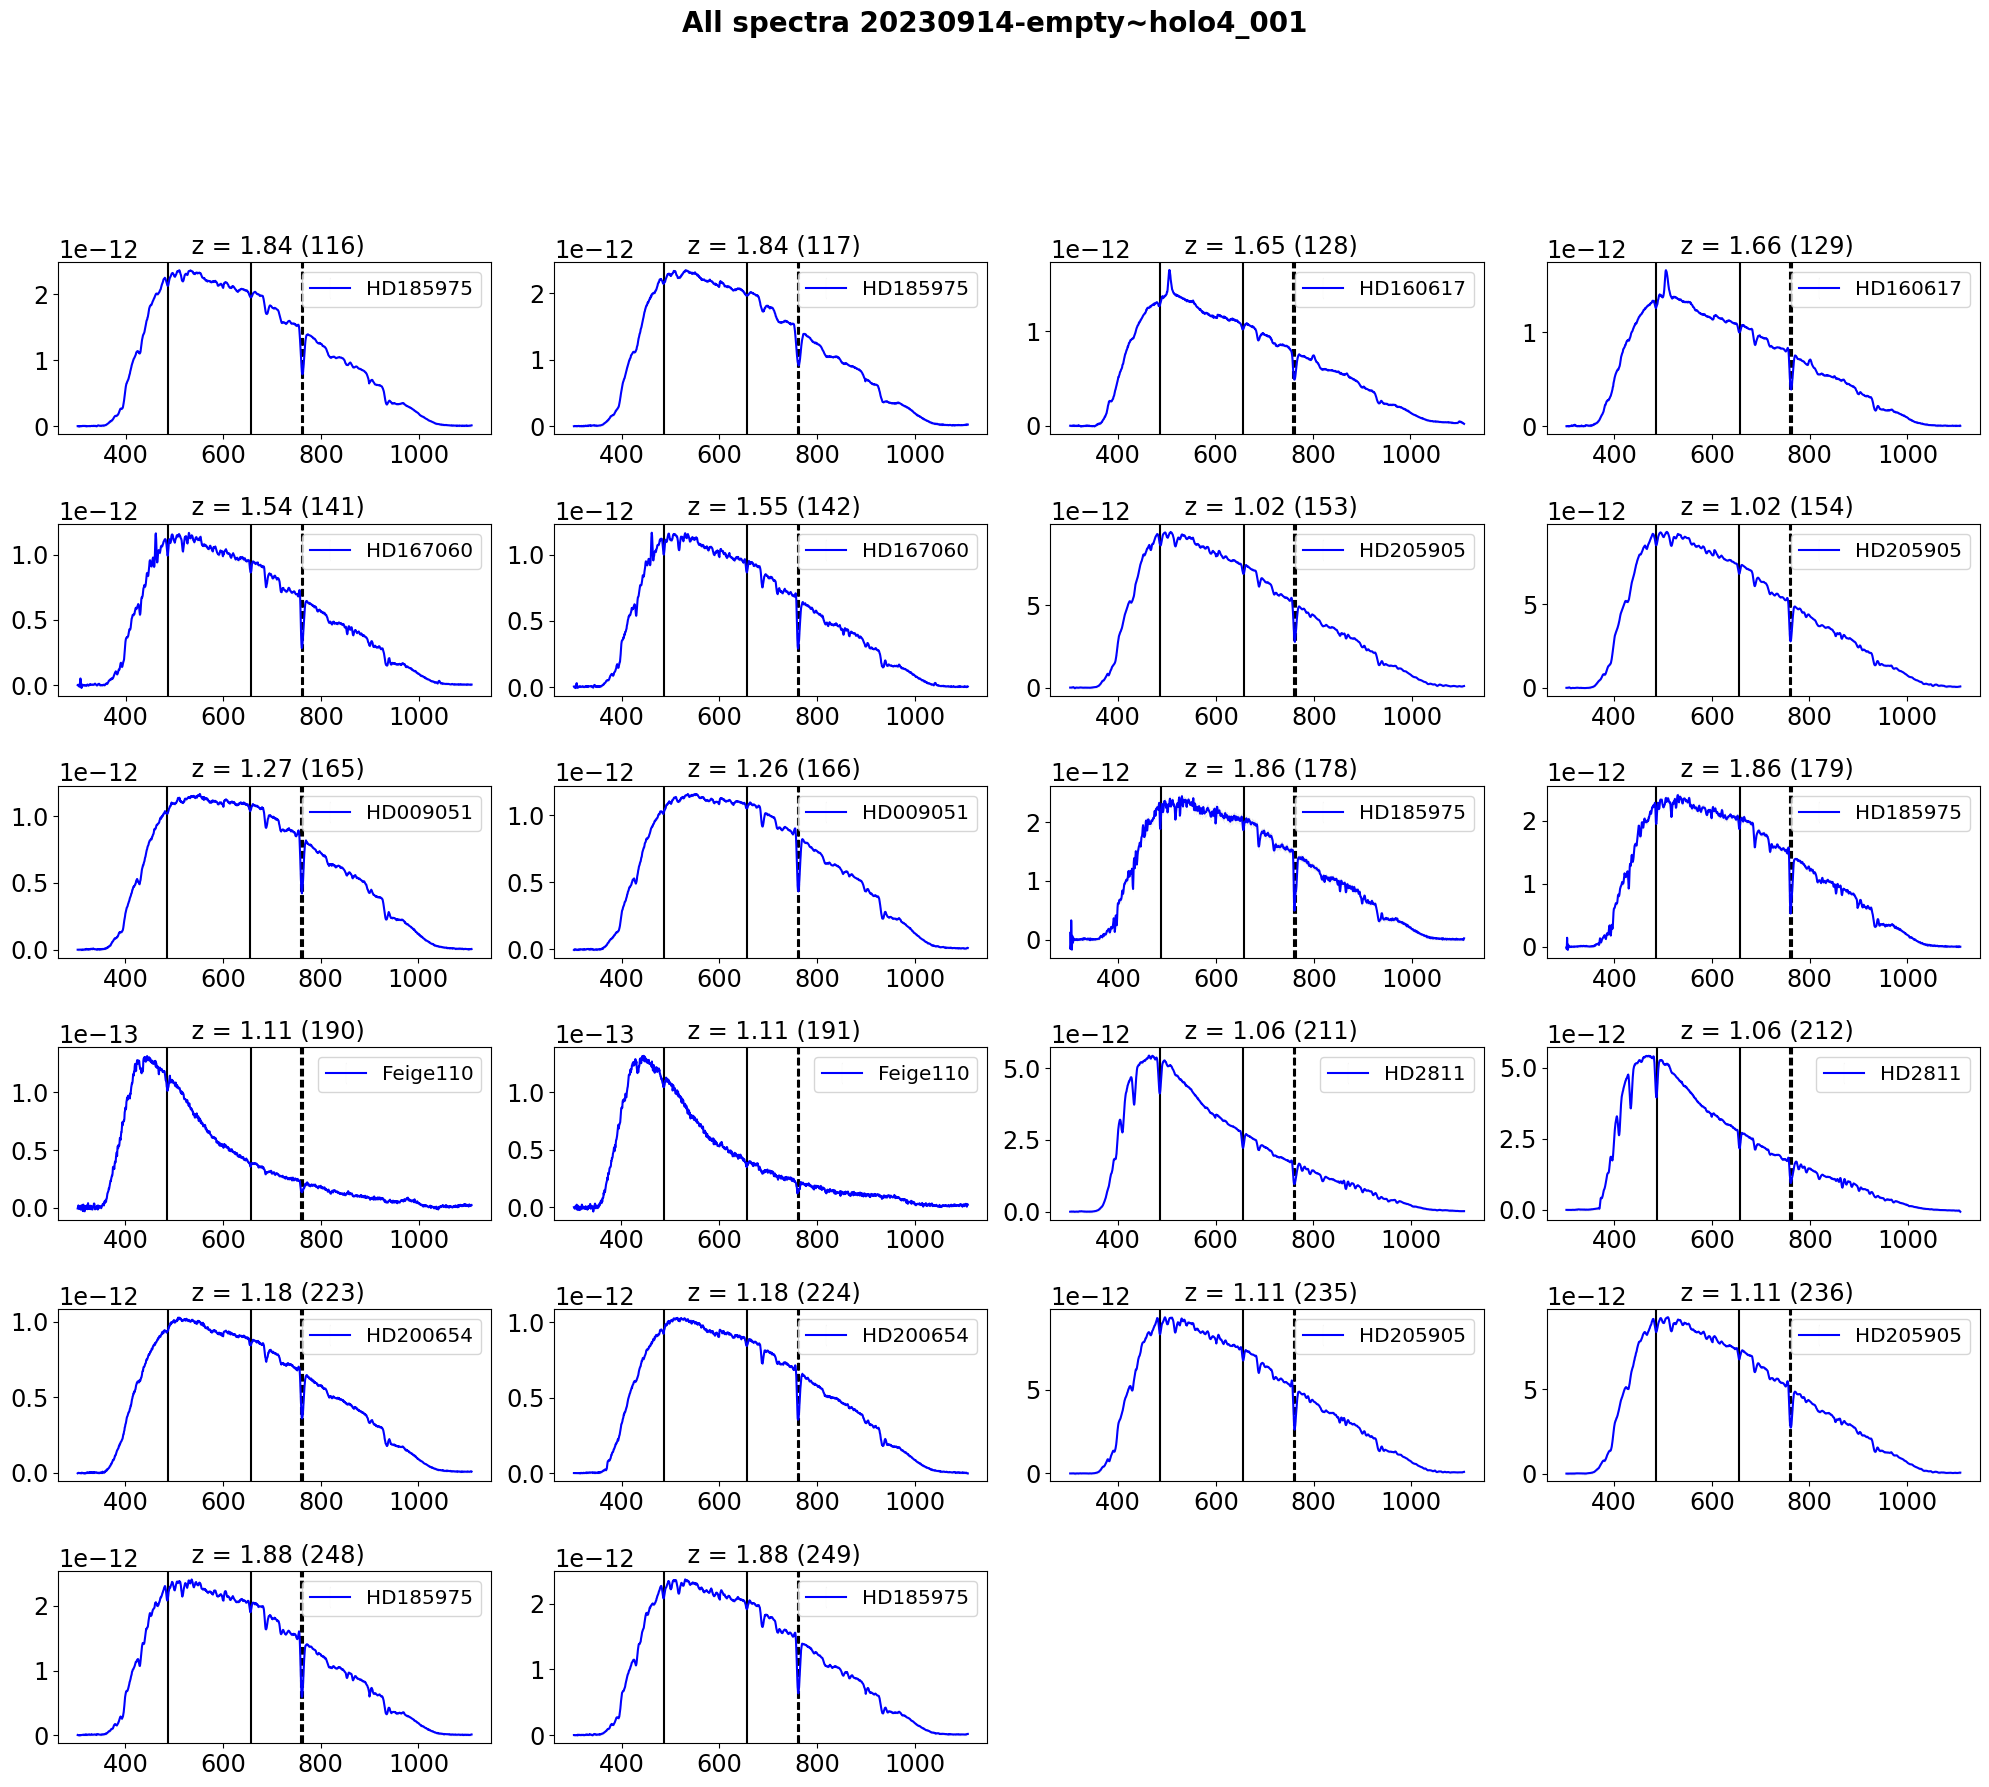

In [53]:
plotallspectra(the_infos,the_spectra,the_list_of_badnums1,thefilterdisperser)

In [54]:
idxf = 2
the_infos = all_infos[idxf] 
the_spectra = all_allspectra[idxf]
the_list_of_badnums1 = list_bad_nums[idxf]
thefilterdisperser = list_filterdispersers[idxf]

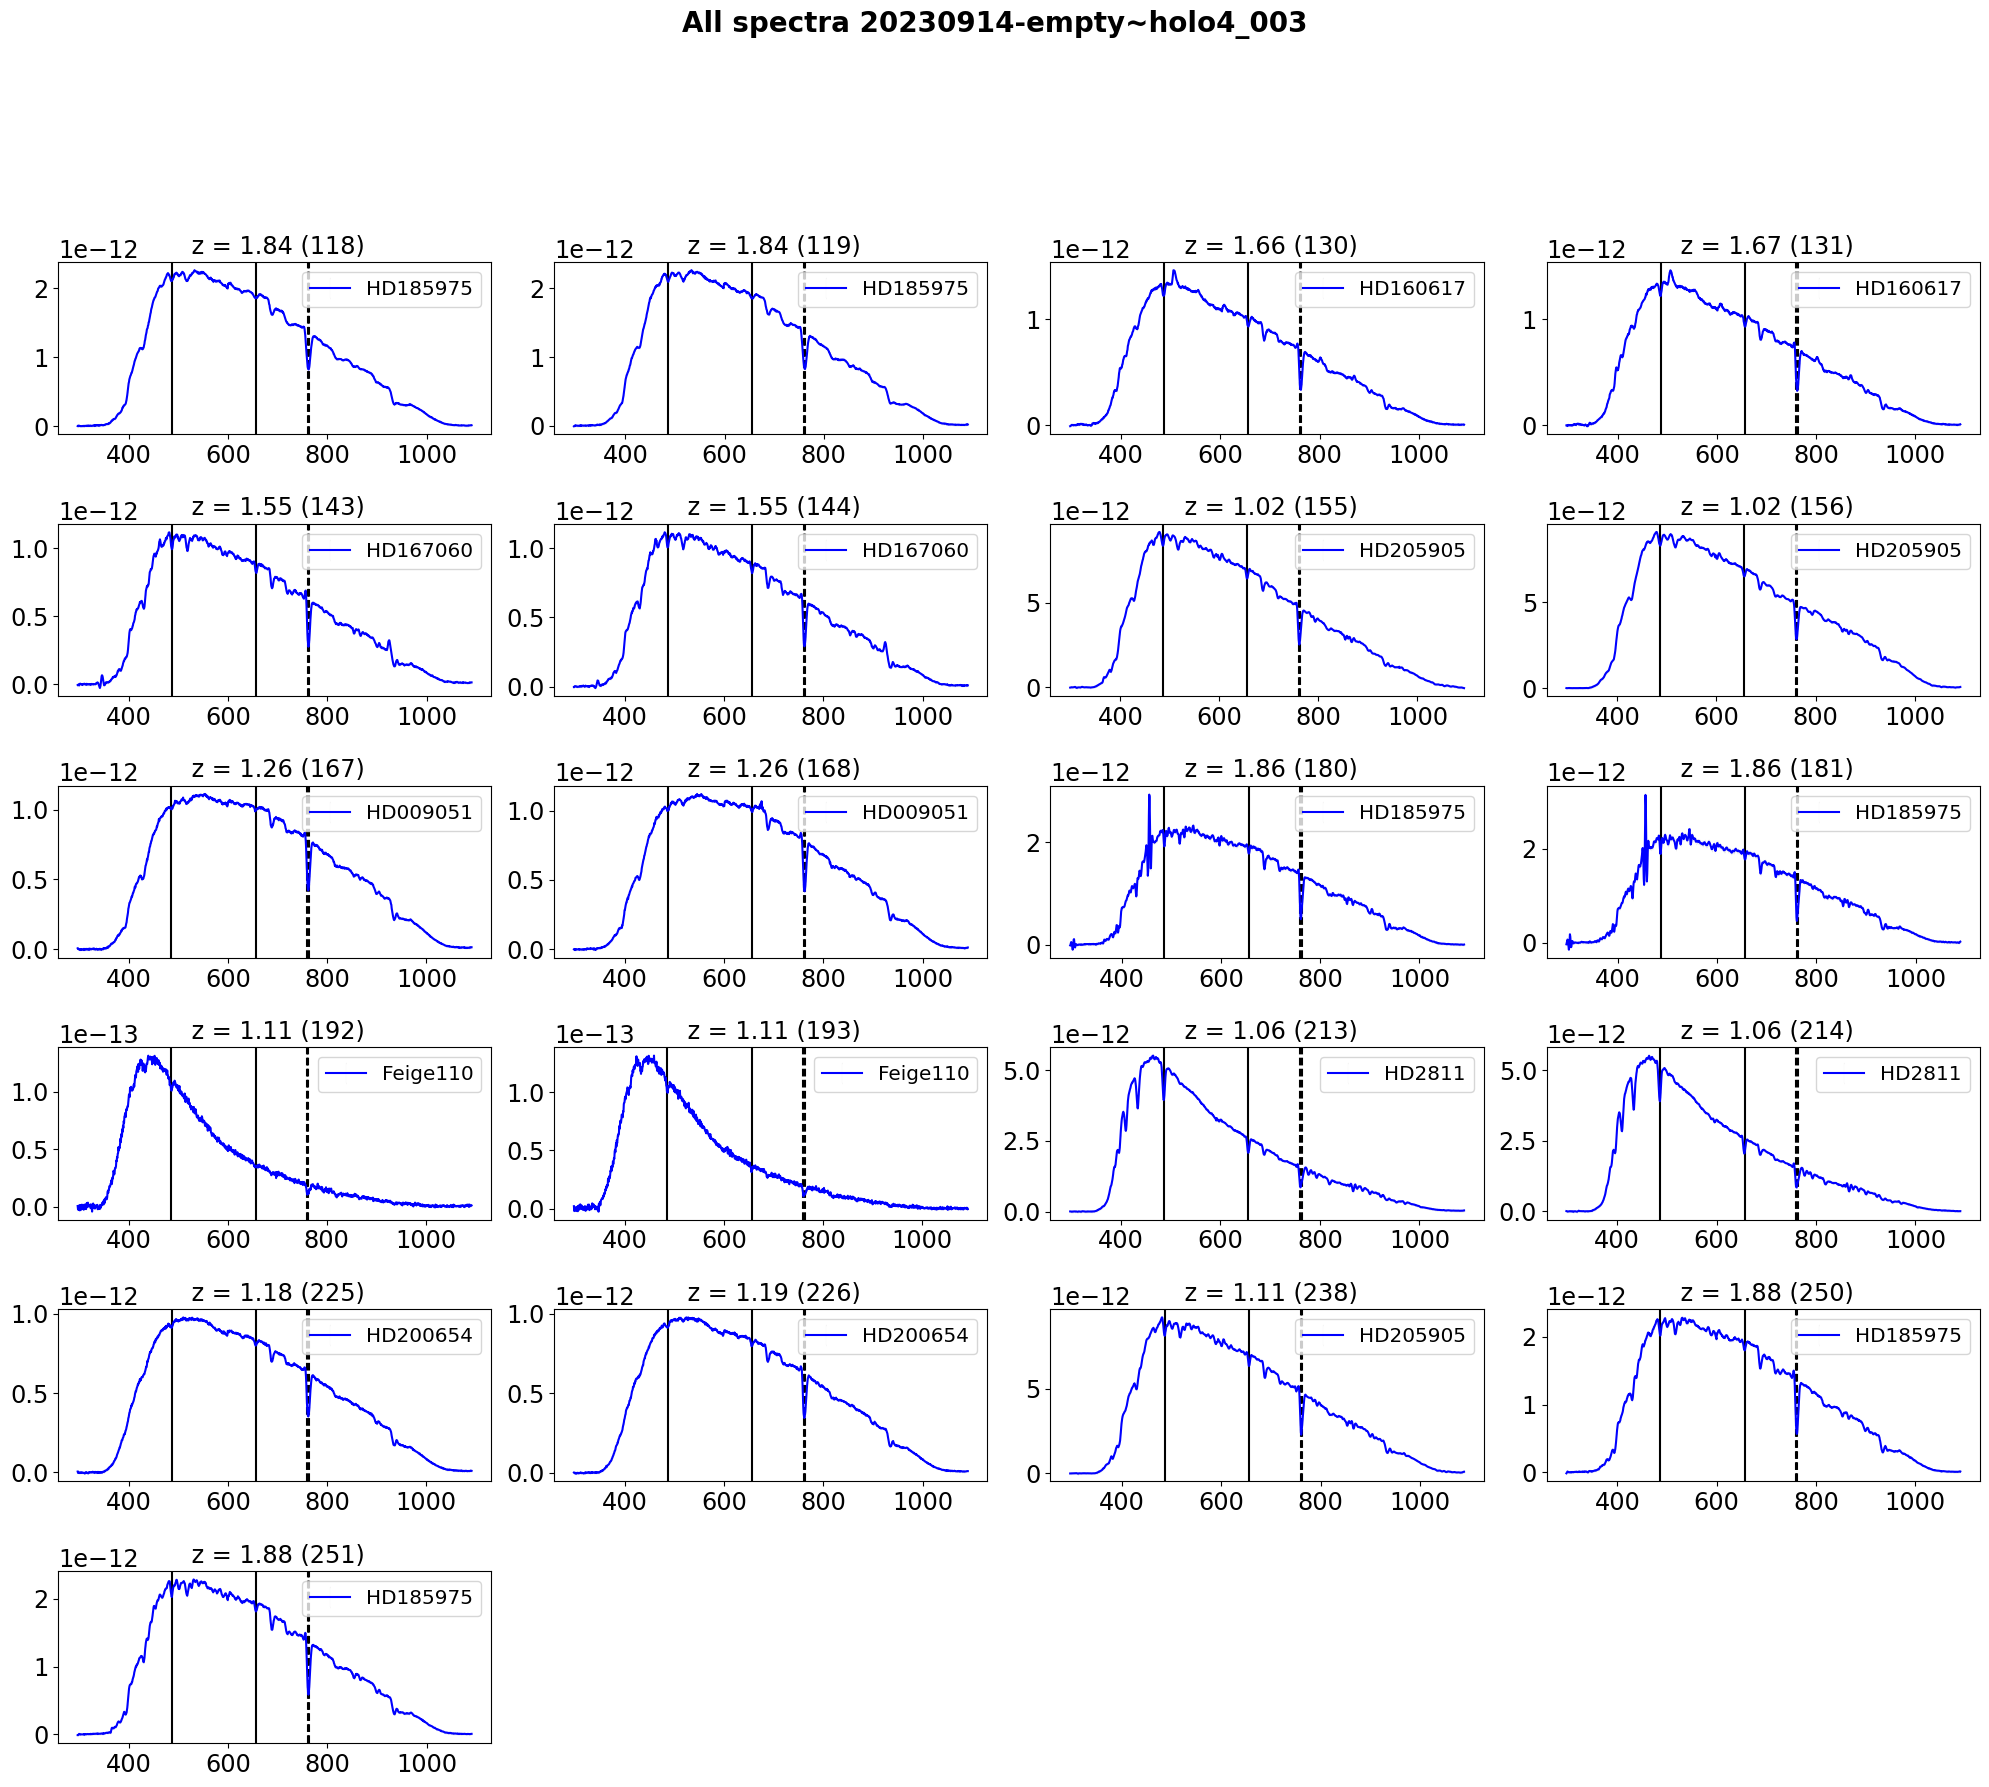

In [55]:
plotallspectra(the_infos,the_spectra,the_list_of_badnums1,thefilterdisperser)

In [56]:
def plotlines(ax,ypos):
    
    ax.axvline(HDELTA.wavelength,color='orange')
    ax.annotate(HDELTA.label, xy=(HDELTA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HGAMMA.wavelength,color='orange')
    ax.annotate(HGAMMA.label, xy=(HGAMMA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HBETA.wavelength,color='orange')
    ax.annotate(HBETA.label, xy=(HBETA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')
    
    ax.axvline(HALPHA.wavelength,color='orange')
    ax.annotate(HALPHA.label, xy=(HALPHA.wavelength, ypos), color='orange',fontsize=20,fontweight='bold')

    ax.axvline(O2B.wavelength,color="blue")
    ax.annotate(O2B.label, xy=(O2B.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_1.wavelength,color="blue")
    #ax.annotate(O2_1.label, xy=(O2_1.wavelength-5, FLUXLIMMAX/2), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(O2_2.wavelength,color="blue")
    ax.annotate(O2_2.label, xy=(O2_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')

    ax.axvline(H2O_1.wavelength,color="blue")
    ax.annotate(H2O_1.label, xy=(H2O_1.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    
    ax.axvline(H2O_2.wavelength,color="blue")
    ax.annotate(H2O_2.label, xy=(H2O_2.wavelength, ypos), color='blue',fontsize=20,fontweight='bold')
    

# Choose the target and plot Spectra

In [57]:
all_infos[0].target_name.unique()

array(['HD185975', 'HD160617', 'HD167060', 'HD205905', 'HD009051',
       'Feige110', 'HD2811', 'HD200654'], dtype=object)

In [58]:
all_infos[1].target_name.unique()

array(['HD185975', 'HD160617', 'HD167060', 'HD205905', 'HD009051',
       'Feige110', 'HD2811', 'HD200654'], dtype=object)

In [59]:
all_infos[2].target_name.unique()

array(['HD185975', 'HD160617', 'HD167060', 'HD205905', 'HD009051',
       'Feige110', 'HD2811', 'HD200654'], dtype=object)

In [60]:
#SELECTEDTARGETNAME = 'HD185975'
#SELECTEDTARGETNAME = 'HD160617'
#SELECTEDTARGETNAME = 'HD167060'
#SELECTEDTARGETNAME = 'HD205905'
#SELECTEDTARGETNAME = 'HD009051'
SELECTEDTARGETNAME =  'Feige110' 
#SELECTEDTARGETNAME = 'HD2811'
#SELECTEDTARGETNAME = 'HD200654'
#SELECTEDTARGETNAME = 'HD14943'

In [61]:
all_infos[0].head()

,index,exposure,expo_instrument,expo_id,physical_filter,obs_id,exposure_time,dark_time,observation_type,observation_reason,...,spec_spectrogram_xmin,spec_spectrogram_xmax,spec_spectrogram_ymin,spec_spectrogram_ymax,spec_spectrogram_deg,spec_spectrogram_saturation,spec_spectrogram_Nx,spec_spectrogram_Ny,refhour,number
0,4,2023091400120,LATISS,2023091400120,collimator~holo4_003,AT_O_20230914_000120,30.0,30.2388,science,object,...,631,1685,784,969,2,22666.666667,1054,185,0.000000,120
1,5,2023091400121,LATISS,2023091400121,collimator~holo4_003,AT_O_20230914_000121,30.0,30.2348,science,object,...,631,1685,783,968,2,22666.666667,1054,185,0.011944,121
2,6,2023091400132,LATISS,2023091400132,collimator~holo4_003,AT_O_20230914_000132,30.0,30.2380,science,object,...,626,1680,775,960,2,22666.666667,1054,185,0.154444,132
3,7,2023091400133,LATISS,2023091400133,collimator~holo4_003,AT_O_20230914_000133,30.0,30.2347,science,object,...,625,1678,776,961,2,22666.666667,1053,185,0.166111,133
4,8,2023091400145,LATISS,2023091400145,collimator~holo4_003,AT_O_20230914_000145,30.0,30.2399,science,object,...,632,1686,781,966,2,22666.666667,1054,185,0.430278,145


In [62]:
all_selectedindexes = []
all_selected_infos =[]
for idxf in range(3):
    df = all_infos[idxf]
    cut =  df['target_name'] == SELECTEDTARGETNAME
    listofindexes = df.index[df['target_name'] == SELECTEDTARGETNAME].tolist()
    all_selectedindexes.append(np.array(listofindexes )) 
    all_selected_infos.append(df[cut])


### get index of selected Spectra

In [63]:
all_selectedindexes

[array([11, 12]), array([12, 13]), array([12, 13])]

In [64]:
all_selected_infos[0]

,index,exposure,expo_instrument,expo_id,physical_filter,obs_id,exposure_time,dark_time,observation_type,observation_reason,...,spec_spectrogram_xmin,spec_spectrogram_xmax,spec_spectrogram_ymin,spec_spectrogram_ymax,spec_spectrogram_deg,spec_spectrogram_saturation,spec_spectrogram_Nx,spec_spectrogram_Ny,refhour,number
11,16,2023091400194,LATISS,2023091400194,collimator~holo4_003,AT_O_20230914_000194,30.0,30.2443,science,object,...,627,1680,777,962,2,22666.666667,1053,185,1.061111,194
12,17,2023091400195,LATISS,2023091400195,collimator~holo4_003,AT_O_20230914_000195,30.0,30.2338,science,object,...,628,1681,778,963,2,22666.666667,1053,185,1.073056,195


In [65]:
all_selected_infos[1]

,index,exposure,expo_instrument,expo_id,physical_filter,obs_id,exposure_time,dark_time,observation_type,observation_reason,...,spec_spectrogram_xmin,spec_spectrogram_xmax,spec_spectrogram_ymin,spec_spectrogram_ymax,spec_spectrogram_deg,spec_spectrogram_saturation,spec_spectrogram_Nx,spec_spectrogram_Ny,refhour,number
12,17,2023091400190,LATISS,2023091400190,empty~holo4_001,AT_O_20230914_000190,30.0,30.2371,science,object,...,575,1733,780,975,2,22666.666667,1158,195,1.061111,190
13,18,2023091400191,LATISS,2023091400191,empty~holo4_001,AT_O_20230914_000191,30.0,30.2347,science,object,...,574,1733,781,976,2,22666.666667,1159,195,1.073056,191


In [66]:
all_selected_infos[2]

,index,exposure,expo_instrument,expo_id,physical_filter,obs_id,exposure_time,dark_time,observation_type,observation_reason,...,spec_spectrogram_xmin,spec_spectrogram_xmax,spec_spectrogram_ymin,spec_spectrogram_ymax,spec_spectrogram_deg,spec_spectrogram_saturation,spec_spectrogram_Nx,spec_spectrogram_Ny,refhour,number
12,16,2023091400192,LATISS,2023091400192,empty~holo4_003,AT_O_20230914_000192,30.0,30.2422,science,object,...,569,1706,777,962,2,22666.666667,1137,185,1.061111,192
13,17,2023091400193,LATISS,2023091400193,empty~holo4_003,AT_O_20230914_000193,30.0,30.2261,science,object,...,568,1705,777,962,2,22666.666667,1137,185,1.072778,193


Text(0.5, 1.05, '20230914 : Feige110')

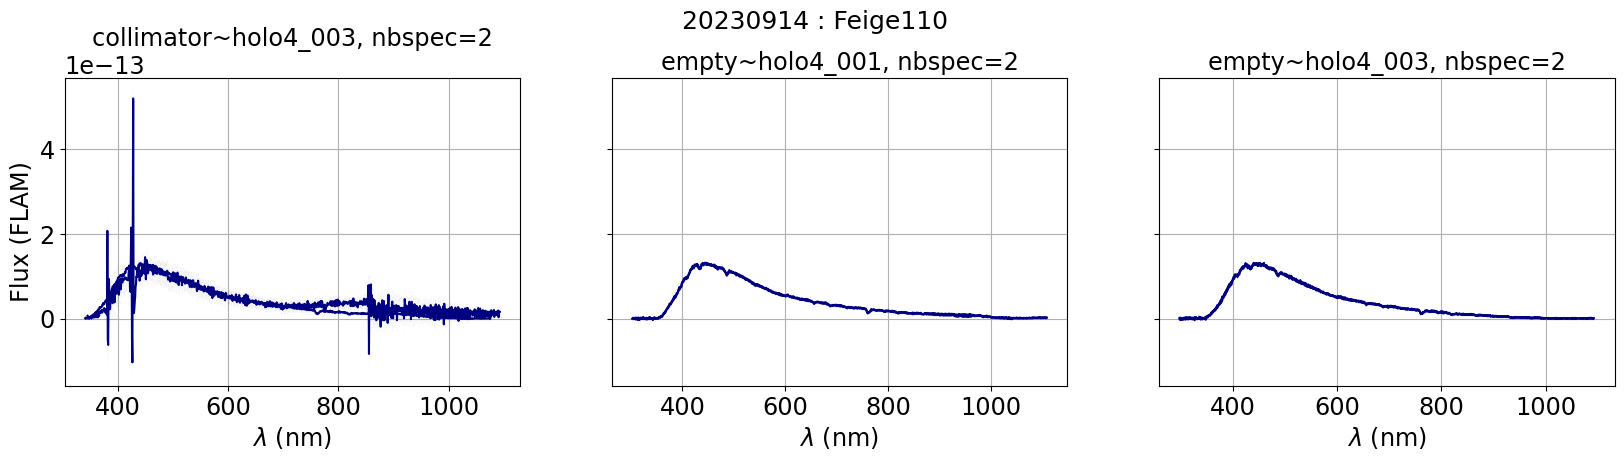

In [67]:
fig, ax = plt.subplots(1, 3,figsize=(20,4),sharey=True)
for idxf in range(3):
    the_infos =  all_infos[idxf]
    the_spectra = all_allspectra[idxf]
    thefilterdisperser = list_filterdispersers[idxf]
    NBSPECTRA = len(all_selectedindexes[idxf])
    # wavelength bin colors
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NBSPECTRA)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NBSPECTRA), alpha=1)
    count=0
    for idx in all_selectedindexes[idxf]:
         the_df = the_spectra[idx]
         ax[idxf].errorbar(the_df["all_lambdas"],the_df['all_fluxes'],yerr=the_df["all_fluxes_err"], color=all_colors[count],fmt = '-',capsize = 0.01, ecolor="k", elinewidth = .01)
    the_title = f"{thefilterdisperser}, nbspec={NBSPECTRA}"
    ax[idxf].set_title(the_title)
    #plotlines(ax[idxf],1e-12)
    #ax[idxf].set_yscale('log')
    count+=1
    ax[idxf].grid()
    ax[idxf].set_xlabel("$\lambda$ (nm)")
    if idxf==0:
        ax[idxf].set_ylabel("Flux (FLAM)")
suptitle = f"{DATE} : {SELECTEDTARGETNAME}"
plt.suptitle(suptitle,fontsize=18,y=1.05)
        

# Compare Spectra

In [68]:
def Interpolate_Spectra(df,index):
    the_df = df[index]
    x = the_df["all_lambdas"]
    y = the_df["all_fluxes"]
    
    f = interpolate.interp1d(x,y, bounds_error=False,fill_value="extrapolate")
    return f(WL)
    

### Subsequents observations

In [69]:
dxf = 0 # choose collimator
the_spectra = all_allspectra[idxf]
the_selected_indexes = all_selectedindexes[idxf]
the_selected_indexes
spec1 = Interpolate_Spectra(the_spectra,the_selected_indexes[0])
spec2 = Interpolate_Spectra(the_spectra,the_selected_indexes[1])

In [70]:
idxf1=1 # empty holo4_001 
the_selected_indexes1 = all_selectedindexes[idxf1]
the_spectra1 = all_allspectra[idxf1]
spec3 = Interpolate_Spectra(the_spectra1,the_selected_indexes1[0])
spec4 = Interpolate_Spectra(the_spectra1,the_selected_indexes1[1])

In [71]:
idxf2=2 # empty holo4_003 
the_selected_indexes2 = all_selectedindexes[idxf2]
the_spectra2 = all_allspectra[idxf2]
spec5 = Interpolate_Spectra(the_spectra2,the_selected_indexes2[0])
spec6 = Interpolate_Spectra(the_spectra2,the_selected_indexes2[1])

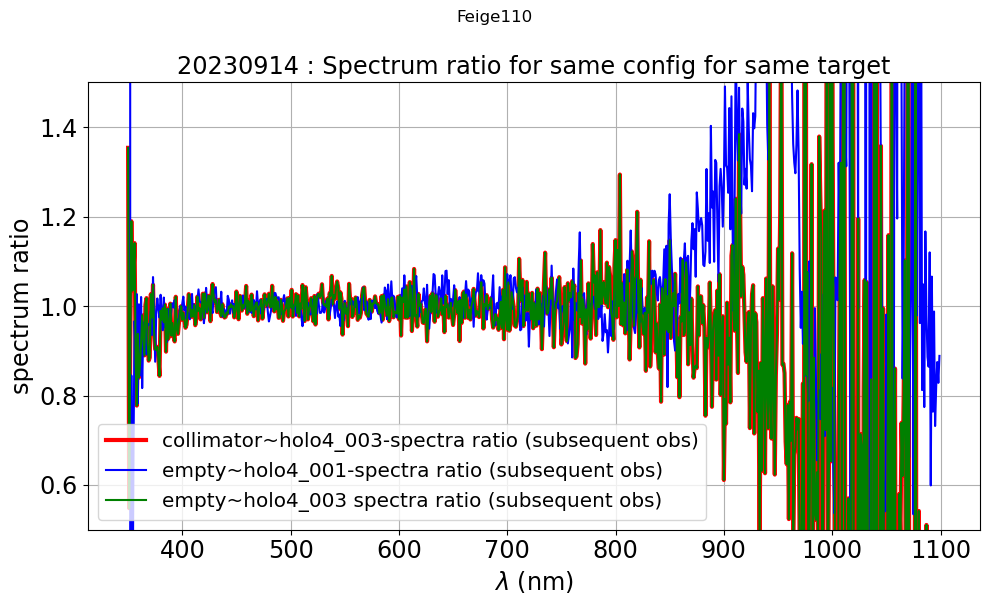

In [72]:
plt.plot(WL,spec2/spec1,'r',label="collimator~holo4_003-spectra ratio (subsequent obs)",lw=3)
plt.plot(WL,spec4/spec3,'b',label="empty~holo4_001-spectra ratio (subsequent obs)")
plt.plot(WL,spec6/spec5,'g',label="empty~holo4_003 spectra ratio (subsequent obs)")
plt.grid()
plt.legend()
the_title= f"{DATE} : Spectrum ratio for same config for same target"
plt.title(the_title)
plt.suptitle(SELECTEDTARGETNAME,y=1)
plt.ylim(0.5,1.5)
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("spectrum ratio")
plt.tight_layout()

### Different dispersers

In [73]:
idxf = 0 # choose collimator
the_spectra = all_allspectra[idxf]
the_selected_indexes = all_selectedindexes[idxf]
the_selected_indexes

array([11, 12])

In [74]:
spec1 = Interpolate_Spectra(the_spectra,the_selected_indexes[0])
spec2 = Interpolate_Spectra(the_spectra,the_selected_indexes[1])

In [75]:
idxf1=1 # empty holo4_001 
the_selected_indexes1 = all_selectedindexes[idxf1]
the_spectra1 = all_allspectra[idxf1]
spec3 = Interpolate_Spectra(the_spectra1,the_selected_indexes1[0])


In [76]:
idxf2=2 # empty holo4_003 
the_selected_indexes2 = all_selectedindexes[idxf2]
the_spectra2 = all_allspectra[idxf2]
spec4 = Interpolate_Spectra(the_spectra2,the_selected_indexes2[0])

In [77]:
#plt.plot(WL,spec2/spec1,'r',label="collimator~holo4_003-spectra ratio (subsequent obs)")
#plt.plot(WL,spec3/spec1,'b',label="empty~holo4_001/collimator~holo4_003-spectra ratio")
#plt.plot(WL,spec4/spec1,'g',label="empty~holo4_003/collimator~holo4_003-spectra ratio")
#plt.grid()
#plt.legend()
#the_title = f"{DATE} : Spectrum ratio for same target, but different config"
#plt.title(the_title)
#plt.suptitle(SELECTEDTARGETNAME,y=1)
#plt.ylim(0.5,1.5)
#plt.xlabel("$\lambda$ (nm)")
#plt.ylabel("spectrum ratio")
#plt.tight_layout()

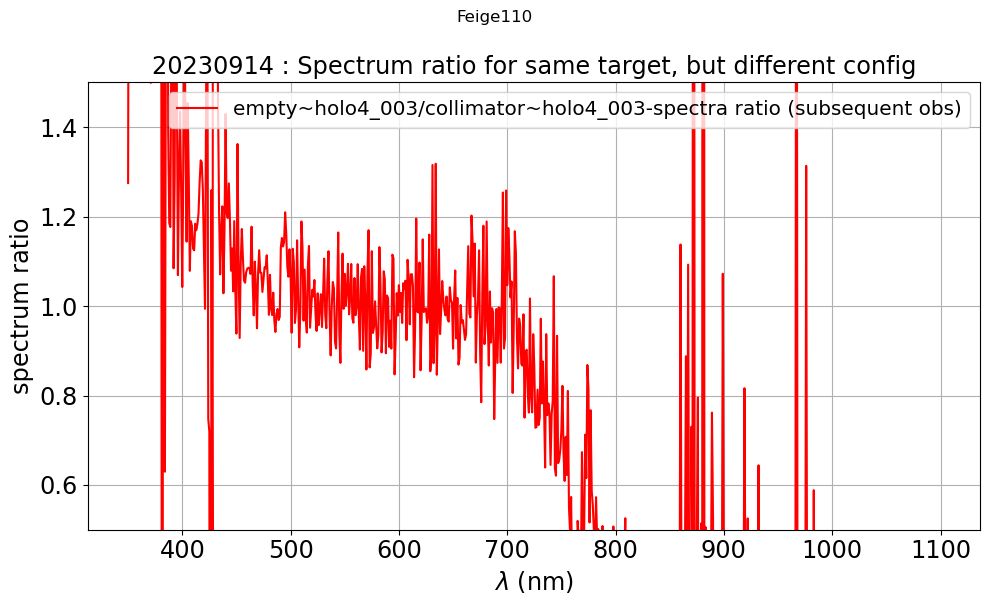

In [78]:
plt.plot(WL,spec4/spec1,'r',label="empty~holo4_003/collimator~holo4_003-spectra ratio (subsequent obs)")
#plt.plot(WL,spec4/spec1,'g',label="empty~holo4_003/collimator~holo4_003-spectra ratio")
plt.grid()
plt.legend()
the_title = f"{DATE} : Spectrum ratio for same target, but different config"
plt.title(the_title)
plt.suptitle(SELECTEDTARGETNAME,y=1)
plt.ylim(0.5,1.5)
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("spectrum ratio")
plt.tight_layout()

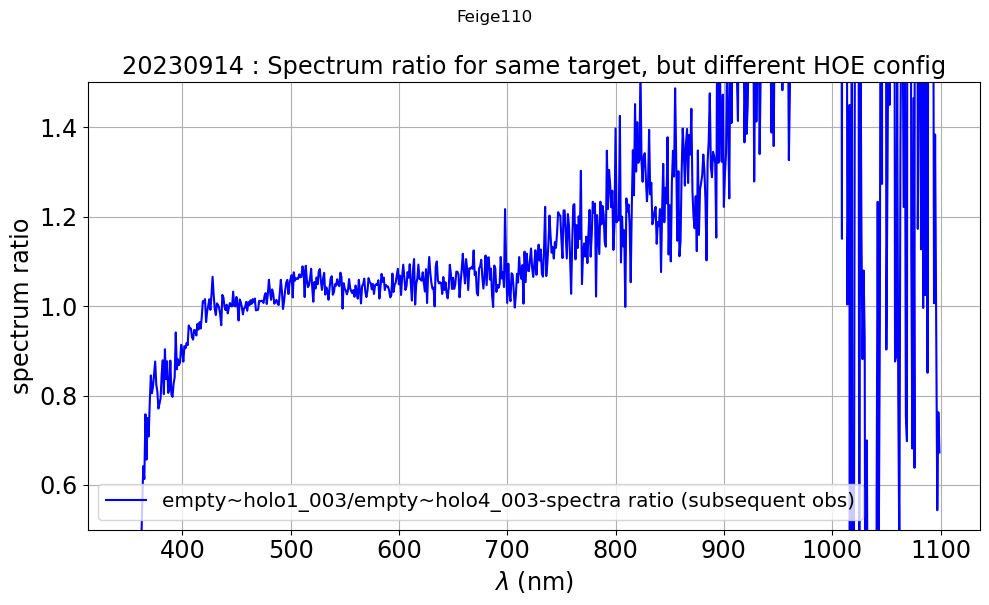

In [79]:
plt.plot(WL,spec3/spec4,'b',label="empty~holo3_001/empty~holo4_003-spectra ratio (subsequent obs)")
#plt.plot(WL,spec4/spec1,'g',label="empty~holo4_003/collimator~holo4_003-spectra ratio")
plt.grid()
plt.legend()
the_title = f"{DATE} : Spectrum ratio for same target, but different HOE config"
plt.title(the_title)
plt.suptitle(SELECTEDTARGETNAME,y=1)
plt.ylim(0.5,1.5)
plt.xlabel("$\lambda$ (nm)")
plt.ylabel("spectrum ratio")
plt.tight_layout()

# Now Work with Holo4_001